In [1]:
from kan import *
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import numpy as np

In [2]:
dim = 1
np_i = 30
ranges = [-1, 1]
log = 1

In [3]:
model = KAN(width=[1, 3, 3, 1], grid=5, k=3, seed=0, auto_save=False)

In [4]:
def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph)[0,:,:]

In [5]:
# define solution
exact_solution = lambda x: torch.sin(torch.pi * x * 8)

In [6]:
source_term = lambda x: torch.pi**2 * torch.sin(torch.pi*x*8)*64

In [7]:
x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)[:,None]
test_x = torch.linspace(-1,1,1000)[:,None]

In [8]:
# boundary, 4 sides
xb1 = x_mesh[0,:]
xb2 = x_mesh[-1,:]
xb = torch.cat([xb1,xb2],dim=0)[:,None]

In [9]:
steps = 200
alpha = 0.1

In [10]:
loss_plot = []
l2_loss_plot = []

In [11]:
def train():
    optimizer = LBFGS(model.parameters(), lr=0.1, history_size=10, line_search_fn="strong_wolfe", 
                      tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='description', ncols=100)
    
    for _ in pbar:
        def closure():
            global pde_loss, bc_loss, loss
            optimizer.zero_grad()
            # interior loss
            d1 = lambda x: batch_jacobian(model, x, create_graph=True)
            u_xx = batch_jacobian(d1, x_mesh, create_graph=True)
            source_u = source_term(x_mesh)
            pde_loss = torch.mean((-u_xx-source_u)**2)
            # boundary loss
            bc_exact_u = exact_solution(xb)
            bc_pred = model(xb)
            bc_loss = torch.mean((bc_exact_u - bc_pred)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        if _ % 5 == 0 and _ < 50:
            model.update_grid_from_samples(x_mesh)

        optimizer.step(closure)
        l2_loss = torch.sqrt(((model(test_x) - exact_solution(test_x))**2).sum(dim=0))
        
        loss = alpha * pde_loss + bc_loss
        loss_plot.append(loss.detach().numpy())
        l2_loss_plot.append(l2_loss.detach().numpy())
        # compute the test loss
        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e " % 
                                (pde_loss.detach().numpy(), 
                                 bc_loss.detach().numpy(), 
                                 ))

In [12]:
train()

pde loss: 5.21e+04 | bc loss: 1.32e+00 : 100%|████████████████████| 200/200 [01:36<00:00,  2.07it/s]


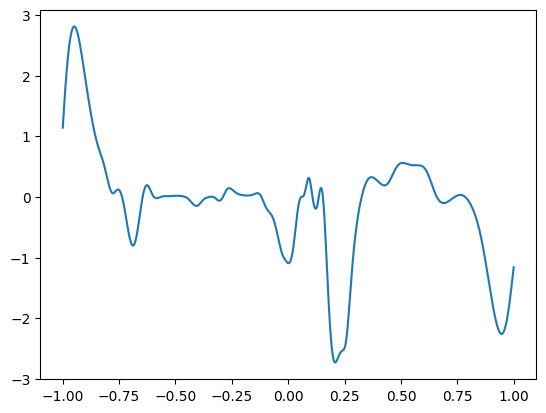

In [13]:
fig, ax = plt.subplots()
ax.plot(test_x.detach().numpy(), model(test_x).detach().numpy())

In [14]:
prediction = model(test_x)

In [16]:
np.savetxt("loss.csv", loss_plot, delimiter=',')
np.savetxt("l2.csv", l2_loss_plot, delimiter=',')

In [18]:
np.savetxt("x.csv", x_mesh.numpy(), delimiter=',')
np.savetxt("prediction.csv", prediction.detach(), delimiter=',')